<a href="https://colab.research.google.com/github/Mikcl/CellTransformer/blob/wip-no-repeat/Cells_are_Transformers_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install linear-attention-transformer
!pip install einops

  Created wheel for product-key-memory: filename=product_key_memory-0.1.10-cp36-none-any.whl size=3072 sha256=30479438a5ee6ac1846fe9829903f510b6f86c46181ce8d6170485c4e4c85d62
  Stored in directory: /root/.cache/pip/wheels/6d/e0/3b/fd3111a4fac652ed014ccfd4757754f006132723985e229419
  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-cp36-none-any.whl size=2904 sha256=e23c2b30f2f04b09ca355328a7e2c1b8ba86504bed26d512c0f6a726cf540c35
  Stored in directory: /root/.cache/pip/wheels/cd/f8/93/25b60e319a481e8f324dcb1871aff818eb0c8143ed20b732b4
Successfully built product-key-memory axial-positional-embedding


In [3]:
import os
import base64
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from IPython.display import Image, HTML, clear_output
import tqdm

import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import matplotlib.pylab as plt
import glob

import torch.optim as optim

from linear_attention_transformer import LinearAttentionTransformerLM
from linear_attention_transformer.autoregressive_wrapper import AutoregressiveWrapper

from einops import rearrange

clear_output()

In [4]:
#@title Cellular Automata Parameters
CHANNEL_N = 4        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40

# 👁, 🦎
TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Growing" #@param ["Growing"] # "Persistent", "Regenerating"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [5]:
#@title Transformer Token Details
TOKEN_OFFSET = 2
NUM_TOKENS = 257 + TOKEN_OFFSET
ENC_SEQ_LEN = 9 * CHANNEL_N
DEC_SEQ_LEN = CHANNEL_N

In [6]:
#@title Tranformer Hyperparameters 

EPOCHS = 401 #int(1e3)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
# GENERATE_EVERY  = 100   # For visual results during training. . 

In [7]:
#@title Helpers 

def to_rgba(x):
  return x[:,:4,:,:]

def to_rgb(x):
  return x[:,:3,:,:]

def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

def plot_loss(loss_log):
  plt.figure(figsize=(10, 4))
  plt.title('Loss history (log10)')
  plt.plot(np.log10(loss_log), '.', alpha=0.1)
  plt.show()

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string


In [8]:
#@title Load image utils. 

# Returns h,w,c image where c=RGBA
def load_image(url, max_size=TARGET_SIZE):
  r = requests.get(url)
  img = PIL.Image.open(io.BytesIO(r.content))
  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  img = np.float32(img)
  return img

def load_emoji(emoji):
  code = hex(ord(emoji))[2:].lower()
  url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u%s.png'%code
  return load_image(url)

In [9]:
#@title To Device
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev)  

In [10]:
#@title Load Emoji
target_img = load_emoji(TARGET_EMOJI)

In [11]:
p = TARGET_PADDING
target_img_tensor = torch.from_numpy(target_img)

# (72,72,4)
pad_target = torch.nn.functional.pad(target_img_tensor, pad=(0,0,p,p,p,p), mode='constant', value=0)
h, w = pad_target.shape[:2]

# (CHANNEL_N, 72, 72)
seed = np.zeros([CHANNEL_N, h, w], np.float32)
seed[3:, h//2, w//2] = 255

pad_target = pad_target.permute(2, 0, 1)

In [12]:
pad_target = pad_target.to(device)

def loss_f(x):
    x = x[:,:4,:,:]
    return torch.mean(torch.square(x-pad_target), [-1,-2,-3])

In [13]:
#@title Masking Utils
IMAGE_BATCH_SIZE = 1 #number of images to concurrently train on. 
LIVE_MIN = 0

# Applied on default/non-tokenized values
def get_living_mask(x):
  alpha = x[:, 3:4, :, :]
  return torch.nn.functional.max_pool2d(input=alpha, kernel_size=3, stride=1, padding=1) > LIVE_MIN

# 3d tensor as boolean. 
alive_target_mask = get_living_mask(pad_target[None,...])

def get_dilatied_mask(x):
  # Returns x dilated mask as FloatType 
  output = x.sum(-3) > 0
  output = output.type(torch.FloatTensor)
  kernel = torch.tensor([[1,1,1],[1,1,1],[1,1,1]]).type(torch.FloatTensor)
  dilated = torch.nn.functional.conv2d(output[None,...], kernel[None, None, ...].expand(1, -1, -1, -1), groups=1, padding=1)
  return dilated

def get_living_target(x):
  living_mask = get_living_mask(x)

  # print('SUM OF 1s', torch.sum(torch.flatten(living_mask)))
  living_target_mask = (living_mask & alive_target_mask)
  living_target = pad_target[None,...] * living_target_mask.float()
  living_target = living_target[0]
  return living_target

def mask_target(mask):
  '''
    mask - tensor: 2D - Float

    returns - tensor: 4D - T
  '''
  # returns 4d tensor. 
  target_batch = pad_target[None, ...] * mask
  return target_batch


In [23]:
#@title Define Model

def tokenize(x):
  return (x + 2).long()

def detokenize(x):
  return (x - 2).long()

def percieve(x):
  # x - 4d tensor - N, C, H, W
  _,_,h,w = x.shape
  padded_x = torch.nn.functional.pad(x, pad=(1,1,1,1), mode='constant', value=0)
  stacked_image = torch.cat(
      [padded_x[:,:,i:i+h, j:j+w]  for j in range(3) for i in range(3)]
      ,1
  )
  return stacked_image


# instantiate model
enc = LinearAttentionTransformerLM(
    num_tokens = NUM_TOKENS,
    dim = 512,
    heads = 8,
    depth = 4,
    max_seq_len = ENC_SEQ_LEN,
    one_kv_head = True,
    return_embeddings = True
).to(device)

dec = LinearAttentionTransformerLM(
    num_tokens = NUM_TOKENS,
    dim = 512,
    heads = 8,
    depth = 6,
    causal = True,
    blindspot_size = 1,             # a small blindspot greatly saves on memory
    max_seq_len = DEC_SEQ_LEN,
    one_kv_head = True,
    receives_context = True
).to(device)

dec = AutoregressiveWrapper(dec)

# optimizer

optim = torch.optim.Adam([*enc.parameters(), *dec.parameters()], lr=LEARNING_RATE)


In [19]:
#@title Dataset Generation Helpers. 
SENTENCES = int(alive_target_mask.shape[2] * alive_target_mask.shape[3])

class CellTraining(Dataset):
    def __init__(self, X, Y):
        self.src = X
        self.tgt = Y
        assert X.shape[0] == Y.shape[0], 'Dataset X and Y not of same length'

        b = X.shape[0]
        self.SRC_MASK = torch.ones(b, ENC_SEQ_LEN).bool()
        self.TGT_MASK = torch.ones(b, DEC_SEQ_LEN).bool()

        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        src = self.src[idx]
        tgt = self.tgt[idx]
        src_mask = self.SRC_MASK[idx]
        tgt_mask = self.TGT_MASK[idx] 
        return src.to(device), tgt.to(device), src_mask.to(device), tgt_mask.to(device)


class CellEvaluating(Dataset):
    def __init__(self, X):
        self.src = X
        b = X.shape[0]
        self.SRC_MASK = torch.ones(b, ENC_SEQ_LEN).bool()
        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        src = self.src[idx]
        src_mask = self.SRC_MASK[idx]
        return src.to(device), src_mask.to(device)



def get_start_tokens(number_of_sentences):
    return torch.ones((number_of_sentences, 1)).long().to(device)

def image_to_sentences(x):
  '''
    ## maps a 3D tensor of shape (c, h, w) to a 2D tensor of (h*w, c)
    these are known as sentences or 'patches' of size one
  '''
  return rearrange(x,'c h w -> (h w) c')


def sentences_to_image(x, height, width):
  '''
    ## maps a 2D tesnor of shape (h*w, c) to image/3D tensor shape of (c, h, w)
    inverse of image_to_sentence
    height: int - image dimension
    width: int - image dimension
  '''
  return rearrange(x, '(h w) (p1 p2 c) -> c (h p1) (w p2)', p1 =1, p2 =1, h=height, w=width)


def visualize_batched(x, c=4):
  x = x[:,:c,:,:].cpu().numpy()
  vis1 = np.hstack(np.transpose(x, (0,2,3,1)))
  plt.imshow(vis1)
  plt.show()


def get_X_values(x, mask=None):
  # X values
  percieved_images = percieve(x)
  X_img = percieved_images[0]

  # TODO - optional mask here? 
  X_img = X_img if mask==None else (X_img[None,...] * mask)[0]

  X_seq_un_clean = image_to_sentences(X_img)
  valid_instances = (torch.tensor(X_seq_un_clean).bool().float().sum(dim=-1) != 0).nonzero().flatten().long()

  X_seq_cleaned = X_seq_un_clean[valid_instances]

  X_seq = tokenize(X_seq_cleaned)
  return valid_instances, X_seq


# X - 4d tensor - maybe move this
def get_input_values(x):
  step_output_float_mask = get_dilatied_mask(x).to(device)

  valid_instances, X_seq = get_X_values(x)

  return step_output_float_mask, valid_instances, X_seq

def get_update_values(x, step_float, seen_float):
  training_float = (step_float.bool() ^ seen_float.bool()).float()
  seen_float = (training_float.bool() ^ seen_float.bool()).float()

  # TODO - use training float to extract valid instances
  valid_instances, X_seq = get_X_values(x, training_float)

  return training_float, valid_instances, X_seq, seen_float

def get_X0():
  x0 = np.repeat(seed[None,...], IMAGE_BATCH_SIZE, 0)
  x0 = torch.Tensor(x0).to(device)
  return x0

def create_training_dataset():
  x0 = get_X0()
  x = x0
  prev_N = None
  seen_float = (get_living_mask(x).float() * 0).to(device);

  x_values = []
  y_values = []

  while (prev_N != 0):

    step_output_float_mask, valid_instances, X_seq = get_input_values(x)

    u_step_output_float_mask, u_valid_instances, u_X_seq, seen_float = get_update_values(x, step_output_float_mask, seen_float)
    N = len(u_valid_instances)
    prev_N = N
    if (N != 0):
      training_float_mask, valid_instances, X_seq = u_step_output_float_mask, u_valid_instances, u_X_seq
    else:
      training_float_mask = step_output_float_mask

    y_target = mask_target(training_float_mask.bool().float())[0]

    # Prefix
    prefix = get_start_tokens(X_seq.shape[0])

    # Y valyes from target
    y_seq_un_cleaned = image_to_sentences(y_target)
    y_seq_cleaned = y_seq_un_cleaned[valid_instances]
    y_seq = tokenize(y_seq_cleaned)
    Y_seq = torch.cat([prefix, y_seq], 1)

    # Add X_seq, Y_seq to a dataset
    x_values.append(X_seq)
    y_values.append(Y_seq)

    x = mask_target(step_output_float_mask.bool().float()).to(device)

  X_seqs = torch.cat(x_values, 0)
  Y_seqs = torch.cat(y_values, 0)
  training_dataset = CellTraining(X_seqs, Y_seqs)
  return training_dataset





training epochs:   0%|          | 0/401 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


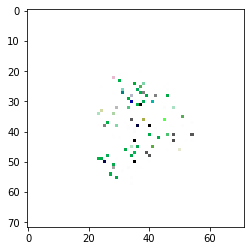

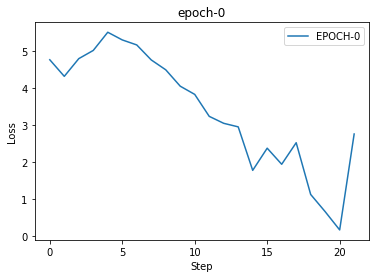



training epochs:   0%|          | 1/401 [00:22<2:27:13, 22.08s/it]



training epochs:   1%|          | 3/401 [00:36<1:57:21, 17.69s/it]



training epochs:   1%|          | 3/401 [00:47<1:57:21, 17.69s/it]

training epochs:   1%|          | 5/401 [00:51<1:36:18, 14.59s/it]



training epochs:   2%|▏         | 7/401 [01:06<1:21:33, 12.42s/it]



training epochs:   2%|▏         | 7/401 [01:17<1:21:33, 12.42s/it]

training epochs:   2%|▏         | 9/401 [01:20<1:11:03, 10.88s/it]



training epochs:   3%|▎         | 11/401 [01:35<1:03:47,  9.81s/it]



training epochs:   3%|▎         | 11/401 [01:47<1:03:47,  9.81s/it]

training epochs:   3%|▎         | 13/401 [01:50<58:31,  9.05s/it]  



training epochs:   4%|▎         | 15/401 [02:04<54:47,  8.52s/it]



training epochs:   4%|▎         | 15/401 [02:17<54:47,  8.52s/it]

training epochs:   4%|▍         | 17/401 [02:19<52:04,  8.14s/it]



training epochs:   5%|▍         | 19/401 [02:33<50:14,  7.89s/it]



training epochs:   5%|▍         | 19/401 [02:47<50:14,  7.89s/it]

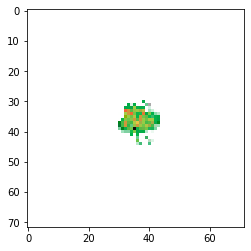

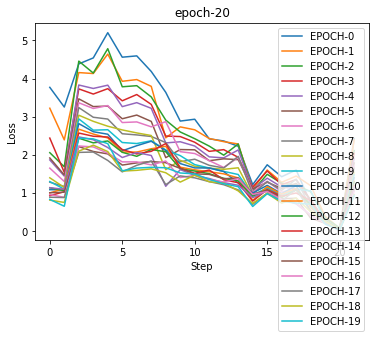



training epochs:   5%|▌         | 21/401 [02:54<55:04,  8.70s/it]



training epochs:   6%|▌         | 23/401 [03:09<52:01,  8.26s/it]



training epochs:   6%|▌         | 25/401 [03:23<49:47,  7.95s/it]



training epochs:   6%|▌         | 25/401 [03:37<49:47,  7.95s/it]

training epochs:   7%|▋         | 27/401 [03:38<48:17,  7.75s/it]



training epochs:   7%|▋         | 29/401 [03:53<47:14,  7.62s/it]



training epochs:   7%|▋         | 29/401 [04:07<47:14,  7.62s/it]

training epochs:   8%|▊         | 31/401 [04:07<46:14,  7.50s/it]



training epochs:   8%|▊         | 33/401 [04:22<45:38,  7.44s/it]



training epochs:   9%|▊         | 35/401 [04:36<45:04,  7.39s/it]



training epochs:   9%|▊         | 35/401 [04:47<45:04,  7.39s/it]

training epochs:   9%|▉         | 37/401 [04:51<44:44,  7.37s/it]

KeyboardInterrupt: ignored

In [22]:
#@title Training { vertical-output: true}

# training
log_loss = []
UPDATE_STEPS = 22 # 21 for full image, 21 + 1 for full image plus train on full.
SENTENCE_BATCH = 32
TRAIN_ON=True 
EVAL_STEPS = 27
VISUALISE_EVERY = 20

next_token_loss = [['EPOCH', 'STEP', 'LOSS']]
epoch_losses = []

for i in tqdm.tqdm(range(EPOCHS), mininterval=10., desc='training epochs'):
    x = get_X0()

    step_loss = []

    seen_float = (get_living_mask(x).float() * 0).to(device);
    prev_N = 0
    
    for step in tqdm.auto.tqdm(range(UPDATE_STEPS), mininterval=1., desc='update step'):
      update_step_loss = []
      step_output_float_mask, valid_instances, X_seq = get_input_values(x)

      if (TRAIN_ON): 
        u_step_output_float_mask, u_valid_instances, u_X_seq, seen_float = get_update_values(x, step_output_float_mask, seen_float)
        N = len(u_valid_instances)

        if (N != 0):
          training_float_mask, valid_instances, X_seq = u_step_output_float_mask, u_valid_instances, u_X_seq
        else:
          training_float_mask = step_output_float_mask

        # target 
        y_target = mask_target(training_float_mask.bool().float())[0]
        # Extend y _ target channels here.

        # Prefix
        prefix = get_start_tokens(X_seq.shape[0])

        # Y valyes from target
        y_seq_un_cleaned = image_to_sentences(y_target)
        y_seq_cleaned = y_seq_un_cleaned[valid_instances]
        y_seq = tokenize(y_seq_cleaned)
        Y_seq = torch.cat([prefix, y_seq], 1)

        # Derive dataset for training.
        dataset = CellTraining(X_seq, Y_seq)
        BS = 1 if X_seq.shape[0] < 20 else SENTENCE_BATCH 
        # Do sentence batch for all except the keep steady step? 
        # 9, 16, 24, 32, 38, 48, 53, 57, 65, 74, 78, 84, 79, 70, 70, 55, 56, 37, 36, 28, 6, 1015
        data_loader = DataLoader(dataset=dataset, batch_size=BS, shuffle=True)
           
        enc.train(), dec.train()
        for batch_i , (src, tgt, src_mask, tgt_mask) in enumerate(data_loader):
          context = enc(src, input_mask = src_mask)
          loss = dec(tgt, context = context, input_mask = tgt_mask, context_mask = src_mask, return_loss = True)
          loss.backward()
          loss_value = loss.item()
          next_token_loss.append([i, step, loss_value])
          update_step_loss.append(loss_value)
          optim.step()
          optim.zero_grad()
        step_loss.append(sum(update_step_loss)/len(update_step_loss))

      x = mask_target(step_output_float_mask.bool().float()).to(device)

    epoch_losses.append(step_loss)

    # Generate:
    if (EVAL_STEPS > 0 and i % VISUALISE_EVERY == 0):
      x = get_X0() # x # get_X0()
      udis = []
      enc.eval(), dec.eval()
      for step in tqdm.auto.tqdm(range(EVAL_STEPS), mininterval=1., desc='evaluation step'):
        output_seq = torch.zeros(SENTENCES, CHANNEL_N).long().to(device) # image_to_sentences(x[0]).long()

        step_output_float_mask, update_instances, X_seq = get_input_values(x)

        update_instances = update_instances

        udis.append(len(update_instances))

        dataset = CellEvaluating(X_seq)
        data_loader = DataLoader(dataset=dataset, batch_size=SENTENCE_BATCH, shuffle=False)
        
        generated= torch.zeros(X_seq.shape[0], CHANNEL_N).long().to(device)

        for batch_i , (src, src_mask) in enumerate(data_loader):
          start_tokens = (torch.ones((src.shape[0], 1)) * 1).long().to(device)

          context = enc(src) # original
          # context = enc(src, input_mask = src_mask) 
          
          sample = dec.generate(start_tokens, DEC_SEQ_LEN , context = context)
          predicted_cells = sample[:, - CHANNEL_N: ]
          s = batch_i*SENTENCE_BATCH
          
          locations = torch.arange(s,s+predicted_cells.shape[0])

          generated[locations] = predicted_cells

        output_seq[update_instances] = detokenize(generated)
        output_img = sentences_to_image(output_seq, x.shape[2], x.shape[3])
        
        x = output_img[None,...]

      visualize_batched(x.detach().clone())
    
    if (TRAIN_ON and i % VISUALISE_EVERY == 0):
      plt.figure()
      for ep, l in enumerate(epoch_losses):
        plt.plot(l, label=f'EPOCH-{ep}')

      plt.xlabel("Step")
      plt.ylabel("Loss")
      plt.title(f"epoch-{i}")
      plt.legend()
      plt.show()

      epoch_losses = []

      
    # TODO - produced x - calculate l2 loss and add to log loss - need alignment first

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



training epochs:   0%|          | 0/401 [00:00<?, ?it/s]

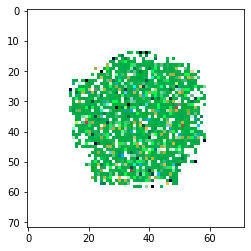

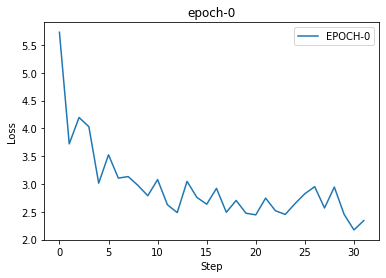




training epochs:   0%|          | 1/401 [00:27<3:03:17, 27.49s/it]


training epochs:   1%|          | 4/401 [00:37<2:13:57, 20.25s/it]


training epochs:   2%|▏         | 8/401 [00:50<1:39:19, 15.16s/it]


training epochs:   3%|▎         | 12/401 [01:03<1:15:10, 11.60s/it]


training epochs:   3%|▎         | 12/401 [01:14<1:15:10, 11.60s/it]


training epochs:   4%|▍         | 16/401 [01:16<58:23,  9.10s/it]  


training epochs:   5%|▍         | 20/401 [01:30<46:41,  7.35s/it]




training epochs:   5%|▍         | 20/401 [01:44<46:41,  7.35s/it]

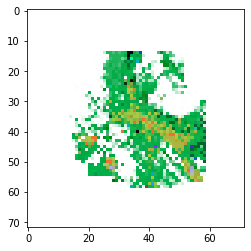

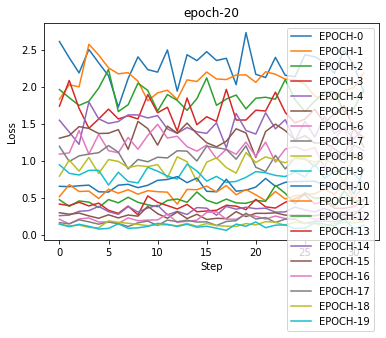




training epochs:   5%|▌         | 21/401 [01:58<1:26:32, 13.67s/it]


training epochs:   6%|▌         | 25/401 [02:11<1:06:07, 10.55s/it]


training epochs:   7%|▋         | 29/401 [02:24<51:54,  8.37s/it]  


training epochs:   7%|▋         | 29/401 [02:34<51:54,  8.37s/it]


training epochs:   8%|▊         | 33/401 [02:37<41:59,  6.85s/it]


training epochs:   9%|▉         | 37/401 [02:51<35:04,  5.78s/it]




training epochs:   9%|▉         | 37/401 [03:04<35:04,  5.78s/it]

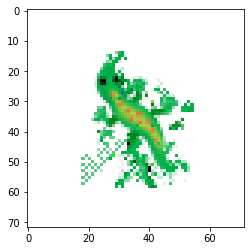

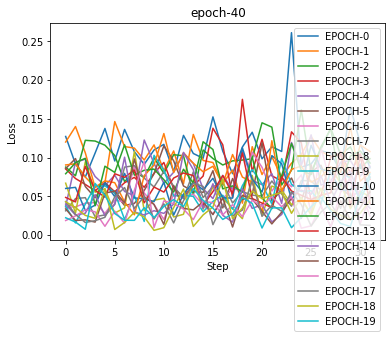




training epochs:  10%|█         | 41/401 [03:27<40:42,  6.78s/it]


training epochs:  11%|█         | 45/401 [03:40<34:00,  5.73s/it]


training epochs:  12%|█▏        | 49/401 [03:53<29:16,  4.99s/it]


training epochs:  12%|█▏        | 49/401 [04:05<29:16,  4.99s/it]


training epochs:  13%|█▎        | 53/401 [04:06<25:58,  4.48s/it]


training epochs:  14%|█▍        | 57/401 [04:19<23:37,  4.12s/it]




training epochs:  14%|█▍        | 57/401 [04:35<23:37,  4.12s/it]

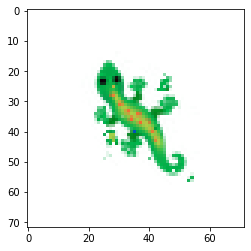

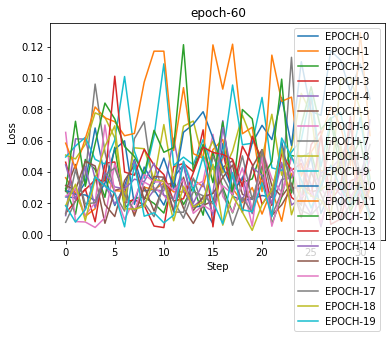




training epochs:  15%|█▌        | 61/401 [04:55<31:16,  5.52s/it]


training epochs:  16%|█▌        | 65/401 [05:08<27:07,  4.84s/it]


training epochs:  17%|█▋        | 69/401 [05:21<24:13,  4.38s/it]


training epochs:  18%|█▊        | 73/401 [05:34<22:08,  4.05s/it]


training epochs:  18%|█▊        | 73/401 [05:45<22:08,  4.05s/it]


training epochs:  19%|█▉        | 77/401 [05:47<20:38,  3.82s/it]




training epochs:  19%|█▉        | 77/401 [06:05<20:38,  3.82s/it]

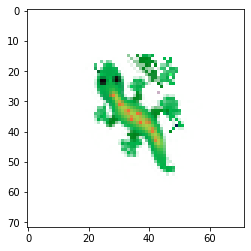

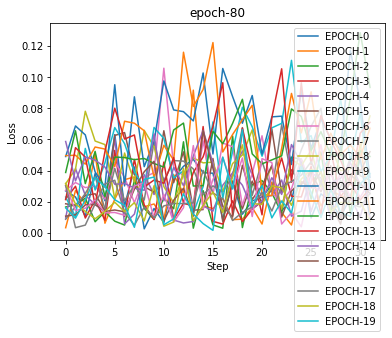




training epochs:  20%|██        | 81/401 [06:22<28:15,  5.30s/it]


training epochs:  20%|██        | 81/401 [06:35<28:15,  5.30s/it]


training epochs:  21%|██        | 85/401 [06:35<24:42,  4.69s/it]


training epochs:  22%|██▏       | 89/401 [06:48<22:11,  4.27s/it]


training epochs:  23%|██▎       | 93/401 [07:01<20:23,  3.97s/it]


training epochs:  24%|██▍       | 97/401 [07:15<19:04,  3.77s/it]


training epochs:  24%|██▍       | 97/401 [07:25<19:04,  3.77s/it]

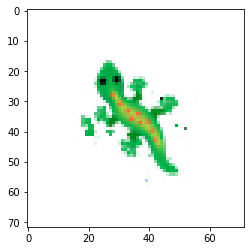

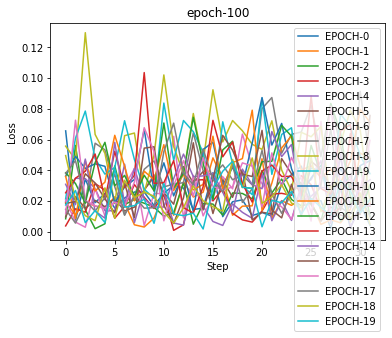




training epochs:  25%|██▌       | 101/401 [07:50<26:24,  5.28s/it]


training epochs:  26%|██▌       | 105/401 [08:03<23:04,  4.68s/it]


training epochs:  26%|██▌       | 105/401 [08:15<23:04,  4.68s/it]


training epochs:  27%|██▋       | 109/401 [08:16<20:43,  4.26s/it]


training epochs:  28%|██▊       | 113/401 [08:29<19:00,  3.96s/it]


training epochs:  29%|██▉       | 117/401 [08:42<17:46,  3.76s/it]


training epochs:  29%|██▉       | 117/401 [08:55<17:46,  3.76s/it]

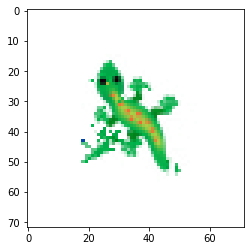

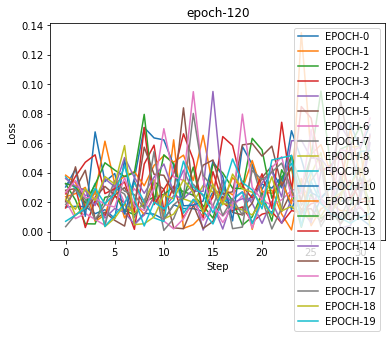




training epochs:  30%|███       | 121/401 [09:17<24:29,  5.25s/it]


training epochs:  31%|███       | 125/401 [09:30<21:25,  4.66s/it]


training epochs:  32%|███▏      | 129/401 [09:43<19:12,  4.24s/it]


training epochs:  32%|███▏      | 129/401 [09:55<19:12,  4.24s/it]


training epochs:  33%|███▎      | 133/401 [09:56<17:39,  3.95s/it]


training epochs:  34%|███▍      | 137/401 [10:10<16:30,  3.75s/it]




training epochs:  34%|███▍      | 137/401 [10:25<16:30,  3.75s/it]

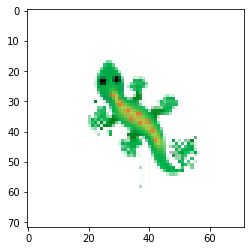

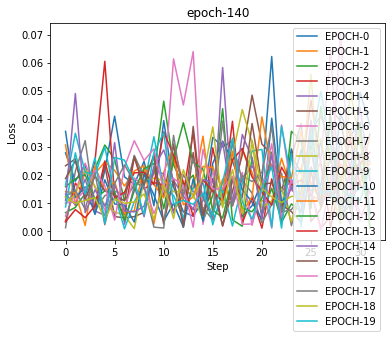




training epochs:  35%|███▌      | 141/401 [10:45<22:54,  5.29s/it]


training epochs:  36%|███▌      | 145/401 [10:58<19:57,  4.68s/it]


training epochs:  37%|███▋      | 149/401 [11:11<17:53,  4.26s/it]


training epochs:  38%|███▊      | 153/401 [11:24<16:23,  3.97s/it]


training epochs:  38%|███▊      | 153/401 [11:35<16:23,  3.97s/it]


training epochs:  39%|███▉      | 157/401 [11:37<15:16,  3.76s/it]




training epochs:  39%|███▉      | 157/401 [11:55<15:16,  3.76s/it]

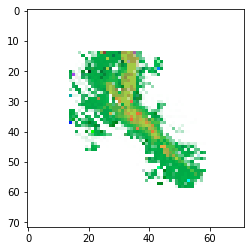

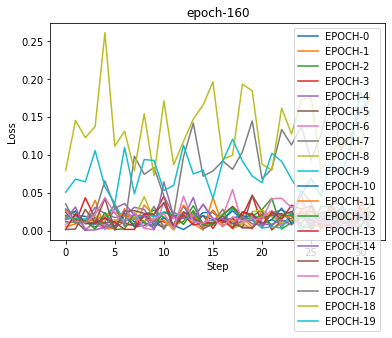




training epochs:  40%|████      | 161/401 [12:12<21:00,  5.25s/it]


training epochs:  40%|████      | 161/401 [12:25<21:00,  5.25s/it]


training epochs:  41%|████      | 165/401 [12:25<18:20,  4.66s/it]


training epochs:  42%|████▏     | 169/401 [12:39<16:25,  4.25s/it]


training epochs:  43%|████▎     | 173/401 [12:52<15:02,  3.96s/it]


training epochs:  43%|████▎     | 173/401 [13:05<15:02,  3.96s/it]


training epochs:  44%|████▍     | 177/401 [13:05<14:00,  3.75s/it]




training epochs:  44%|████▍     | 177/401 [13:25<14:00,  3.75s/it]

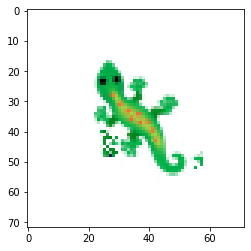

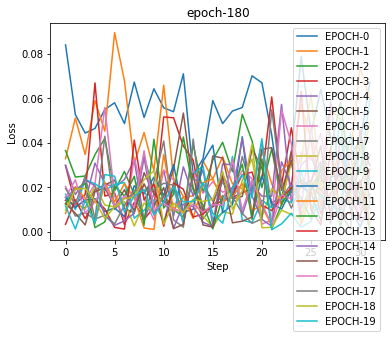




training epochs:  45%|████▌     | 181/401 [13:39<19:05,  5.21s/it]


training epochs:  46%|████▌     | 185/401 [13:52<16:39,  4.63s/it]


training epochs:  46%|████▌     | 185/401 [14:05<16:39,  4.63s/it]


training epochs:  47%|████▋     | 189/401 [14:05<14:54,  4.22s/it]


training epochs:  48%|████▊     | 193/401 [14:19<13:39,  3.94s/it]


training epochs:  49%|████▉     | 197/401 [14:32<12:43,  3.74s/it]


training epochs:  49%|████▉     | 197/401 [14:45<12:43,  3.74s/it]

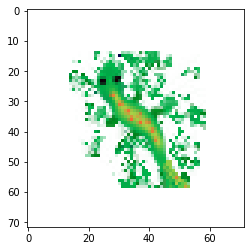

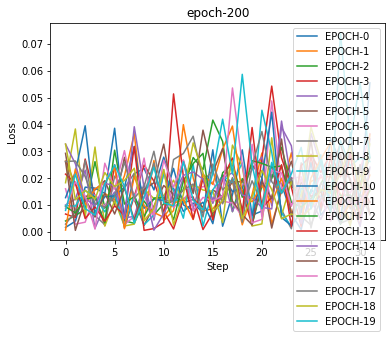




training epochs:  50%|█████     | 201/401 [15:11<18:29,  5.55s/it]


training epochs:  51%|█████     | 205/401 [15:24<15:53,  4.86s/it]


training epochs:  51%|█████     | 205/401 [15:35<15:53,  4.86s/it]


training epochs:  52%|█████▏    | 209/401 [15:37<14:02,  4.39s/it]


training epochs:  53%|█████▎    | 213/401 [15:50<12:42,  4.06s/it]


training epochs:  54%|█████▍    | 217/401 [16:03<11:43,  3.82s/it]


training epochs:  54%|█████▍    | 217/401 [16:15<11:43,  3.82s/it]

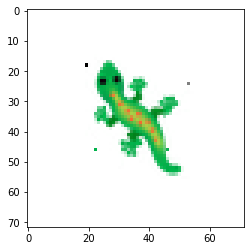

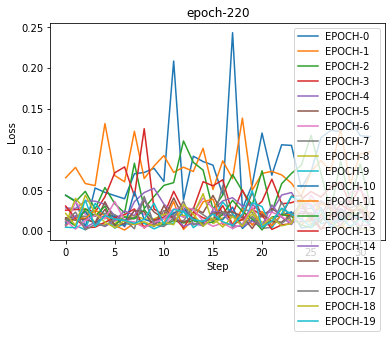




training epochs:  55%|█████▌    | 221/401 [16:37<15:35,  5.19s/it]


training epochs:  56%|█████▌    | 225/401 [16:50<13:33,  4.62s/it]


training epochs:  57%|█████▋    | 229/401 [17:03<12:04,  4.21s/it]


training epochs:  57%|█████▋    | 229/401 [17:15<12:04,  4.21s/it]


training epochs:  58%|█████▊    | 233/401 [17:16<11:00,  3.93s/it]


training epochs:  59%|█████▉    | 237/401 [17:29<10:13,  3.74s/it]




training epochs:  59%|█████▉    | 237/401 [17:45<10:13,  3.74s/it]

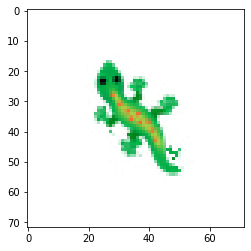

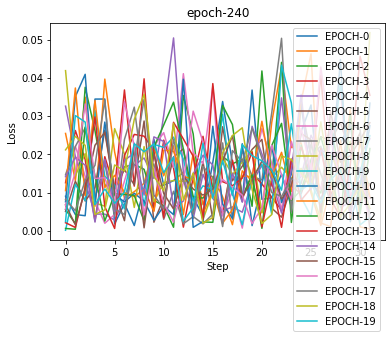




training epochs:  60%|██████    | 241/401 [18:04<13:57,  5.23s/it]


training epochs:  60%|██████    | 241/401 [18:15<13:57,  5.23s/it]


training epochs:  61%|██████    | 245/401 [18:17<12:05,  4.65s/it]


training epochs:  62%|██████▏   | 249/401 [18:30<10:44,  4.24s/it]


training epochs:  63%|██████▎   | 253/401 [18:43<09:44,  3.95s/it]


training epochs:  63%|██████▎   | 253/401 [18:55<09:44,  3.95s/it]


training epochs:  64%|██████▍   | 257/401 [18:57<09:00,  3.75s/it]




training epochs:  64%|██████▍   | 257/401 [19:15<09:00,  3.75s/it]

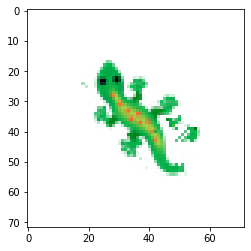

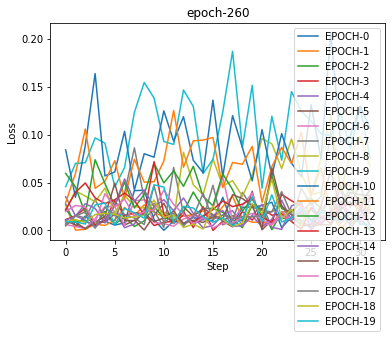




training epochs:  65%|██████▌   | 261/401 [19:31<12:09,  5.21s/it]


training epochs:  66%|██████▌   | 265/401 [19:44<10:29,  4.63s/it]


training epochs:  66%|██████▌   | 265/401 [19:55<10:29,  4.63s/it]


training epochs:  67%|██████▋   | 269/401 [19:57<09:17,  4.22s/it]


training epochs:  68%|██████▊   | 273/401 [20:10<08:24,  3.94s/it]


training epochs:  69%|██████▉   | 277/401 [20:23<07:44,  3.74s/it]


training epochs:  69%|██████▉   | 277/401 [20:35<07:44,  3.74s/it]

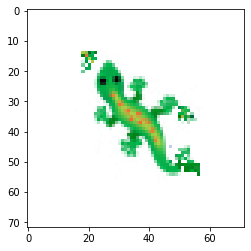

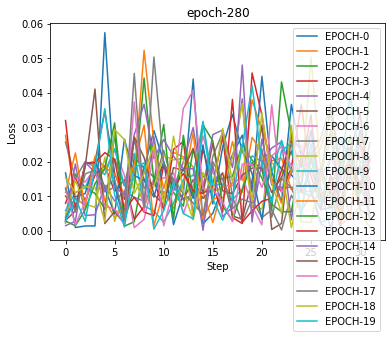




training epochs:  70%|███████   | 281/401 [20:58<10:28,  5.24s/it]


training epochs:  71%|███████   | 285/401 [21:11<08:59,  4.65s/it]


training epochs:  72%|███████▏  | 289/401 [21:25<07:54,  4.24s/it]


training epochs:  72%|███████▏  | 289/401 [21:35<07:54,  4.24s/it]


training epochs:  73%|███████▎  | 293/401 [21:38<07:06,  3.95s/it]


training epochs:  74%|███████▍  | 297/401 [21:51<06:30,  3.75s/it]




training epochs:  74%|███████▍  | 297/401 [22:05<06:30,  3.75s/it]

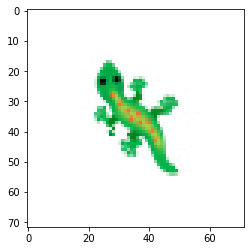

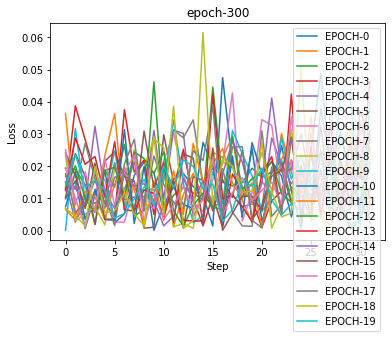




training epochs:  75%|███████▌  | 301/401 [22:25<08:37,  5.17s/it]


training epochs:  75%|███████▌  | 301/401 [22:35<08:37,  5.17s/it]


training epochs:  76%|███████▌  | 305/401 [22:38<07:22,  4.61s/it]


training epochs:  77%|███████▋  | 309/401 [22:51<06:27,  4.21s/it]


training epochs:  78%|███████▊  | 313/401 [23:04<05:46,  3.94s/it]


training epochs:  78%|███████▊  | 313/401 [23:15<05:46,  3.94s/it]


training epochs:  79%|███████▉  | 317/401 [23:17<05:14,  3.74s/it]




training epochs:  79%|███████▉  | 317/401 [23:35<05:14,  3.74s/it]

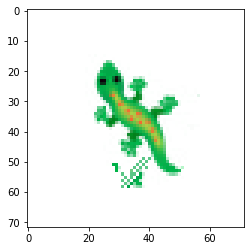

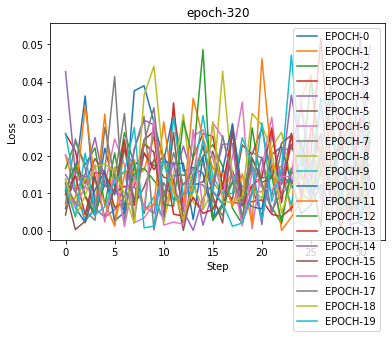




training epochs:  80%|████████  | 321/401 [23:52<06:58,  5.23s/it]


training epochs:  80%|████████  | 321/401 [24:05<06:58,  5.23s/it]


training epochs:  81%|████████  | 325/401 [24:05<05:52,  4.64s/it]


training epochs:  82%|████████▏ | 329/401 [24:19<05:05,  4.24s/it]


training epochs:  83%|████████▎ | 333/401 [24:32<04:28,  3.95s/it]


training epochs:  84%|████████▍ | 337/401 [24:45<04:00,  3.75s/it]


training epochs:  84%|████████▍ | 337/401 [24:55<04:00,  3.75s/it]

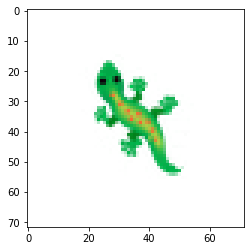

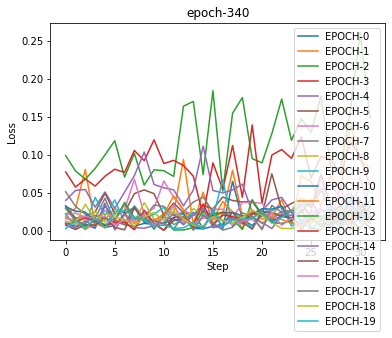




training epochs:  85%|████████▌ | 341/401 [25:19<05:13,  5.22s/it]


training epochs:  86%|████████▌ | 345/401 [25:33<04:20,  4.64s/it]


training epochs:  86%|████████▌ | 345/401 [25:45<04:20,  4.64s/it]


training epochs:  87%|████████▋ | 349/401 [25:46<03:40,  4.24s/it]


training epochs:  88%|████████▊ | 353/401 [25:59<03:09,  3.95s/it]


training epochs:  89%|████████▉ | 357/401 [26:12<02:44,  3.74s/it]


training epochs:  89%|████████▉ | 357/401 [26:25<02:44,  3.74s/it]

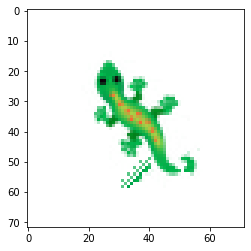

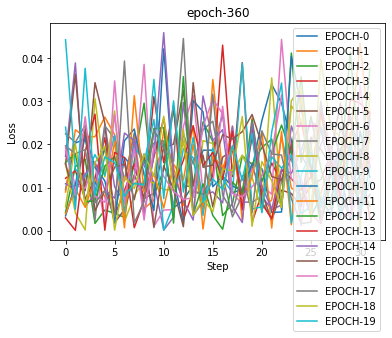




training epochs:  90%|█████████ | 361/401 [26:47<03:30,  5.26s/it]


training epochs:  91%|█████████ | 365/401 [27:00<02:48,  4.67s/it]


training epochs:  92%|█████████▏| 369/401 [27:13<02:16,  4.26s/it]


training epochs:  92%|█████████▏| 369/401 [27:25<02:16,  4.26s/it]


training epochs:  93%|█████████▎| 373/401 [27:27<01:50,  3.96s/it]


training epochs:  94%|█████████▍| 377/401 [27:40<01:30,  3.76s/it]




training epochs:  94%|█████████▍| 377/401 [27:55<01:30,  3.76s/it]

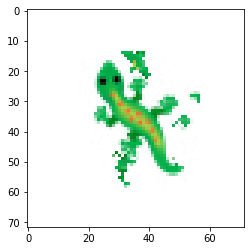

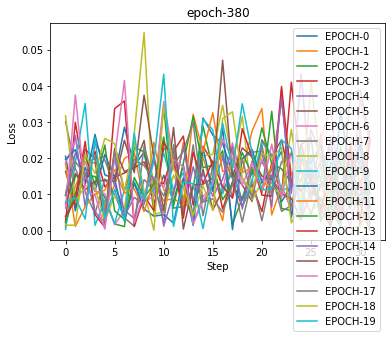




training epochs:  95%|█████████▌| 381/401 [28:16<01:47,  5.37s/it]


training epochs:  96%|█████████▌| 385/401 [28:29<01:15,  4.74s/it]


training epochs:  97%|█████████▋| 389/401 [28:42<00:51,  4.31s/it]


training epochs:  97%|█████████▋| 389/401 [28:55<00:51,  4.31s/it]


training epochs:  98%|█████████▊| 393/401 [28:56<00:31,  4.00s/it]


training epochs:  99%|█████████▉| 397/401 [29:09<00:15,  3.78s/it]




training epochs:  99%|█████████▉| 397/401 [29:25<00:15,  3.78s/it]

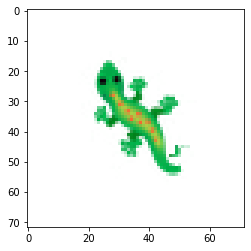

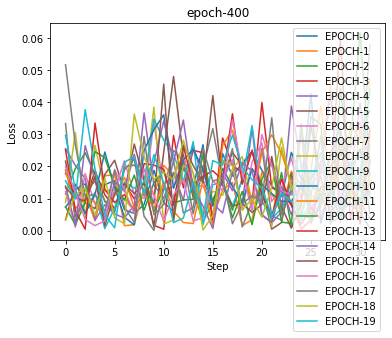




training epochs: 100%|██████████| 401/401 [29:43<00:00,  4.45s/it]


In [24]:
#@title Un-Ordered Training!!!!! { vertical-output: true}

# training
log_loss = []
SENTENCE_BATCH = 32
TRAIN_ON=True 
EVAL_STEPS = 22
VISUALISE_EVERY = 20

next_token_loss = [['EPOCH', 'STEP', 'LOSS']]
epoch_losses = []

training_dataset = create_training_dataset()
data_loader = DataLoader(dataset=training_dataset, batch_size=64, shuffle=True)


for i in tqdm.tqdm(range(EPOCHS), mininterval=10., desc='training epochs'):
    losses = []    
    enc.train(), dec.train()
    for batch_i , (src, tgt, src_mask, tgt_mask) in enumerate(data_loader):
      context = enc(src, input_mask = src_mask)
      loss = dec(tgt, context = context, input_mask = tgt_mask, context_mask = src_mask, return_loss = True)
      loss.backward()
      loss_value = loss.item()
      next_token_loss.append([i, step, loss_value])
      losses.append(loss_value)
      optim.step()
      optim.zero_grad()

    epoch_losses.append(losses)

    # Generate:
    if (EVAL_STEPS > 0 and i % VISUALISE_EVERY == 0):
      x = get_X0()

      enc.eval(), dec.eval()
      for step in tqdm.auto.tqdm(range(EVAL_STEPS), mininterval=1., desc='evaluation step'):
        output_seq = torch.zeros(SENTENCES, CHANNEL_N).long().to(device)

        step_output_float_mask, update_instances, X_seq = get_input_values(x)

        update_instances = update_instances

        dataset = CellEvaluating(X_seq)
        eval_data_loader = DataLoader(dataset=dataset, batch_size=SENTENCE_BATCH, shuffle=False)
        
        generated= torch.zeros(X_seq.shape[0], CHANNEL_N).long().to(device)

        for batch_i , (src, src_mask) in enumerate(eval_data_loader):
          start_tokens = (torch.ones((src.shape[0], 1)) * 1).long().to(device)

          context = enc(src) # original
          
          sample = dec.generate(start_tokens, DEC_SEQ_LEN , context = context)
          predicted_cells = sample[:, - CHANNEL_N: ]
          s = batch_i*SENTENCE_BATCH
          
          locations = torch.arange(s,s+predicted_cells.shape[0])

          generated[locations] = predicted_cells

        output_seq[update_instances] = detokenize(generated)
        output_img = sentences_to_image(output_seq, x.shape[2], x.shape[3])
        
        x = output_img[None,...]

      visualize_batched(x.detach().clone())
    
    if (TRAIN_ON and i % VISUALISE_EVERY == 0):
      plt.figure()
      for ep, l in enumerate(epoch_losses):
        plt.plot(l, label=f'EPOCH-{ep}')

      plt.xlabel("Step")
      plt.ylabel("Loss")
      plt.title(f"epoch-{i}")
      plt.legend()
      plt.show()

      epoch_losses = []

      
    # TODO - produced x - calculate l2 loss and add to log loss - need alignment first